In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle
cle.select_device('RTX')
print("Using OpenCL device " + cle.get_device().name)

import math
import numpy as np
import pandas as pd
import cv2
import tifffile
import os
import nrrd

from oiffile import OifFile
from confocal_3D.OifImageViewer import OifImageViewer

Using OpenCL device NVIDIA RTX A5000


In [2]:
path = "/home/dkermany/data/Bone_Project/oibs/FV10__20190620_111343.oib"
filename = os.path.splitext(os.path.basename(path))[0]

with OifFile(path) as oif:
    viewer = OifImageViewer(oif)
    x_step, y_step, z_step = map(float, (viewer.md["x_step"], viewer.md["y_step"], viewer.md["z_step"]))
    if viewer.md["z_unit"] == "nm":
        z_step /= 1000.

Image shape: (3, 76, 2404, 3376)
Axes: CZYX
Dtype: uint16
Intervals: X (1.242um) Y (1.242um) Z (2660nm)



Load 3D Masks
----------------------

(76, 2404, 3376)
uint16


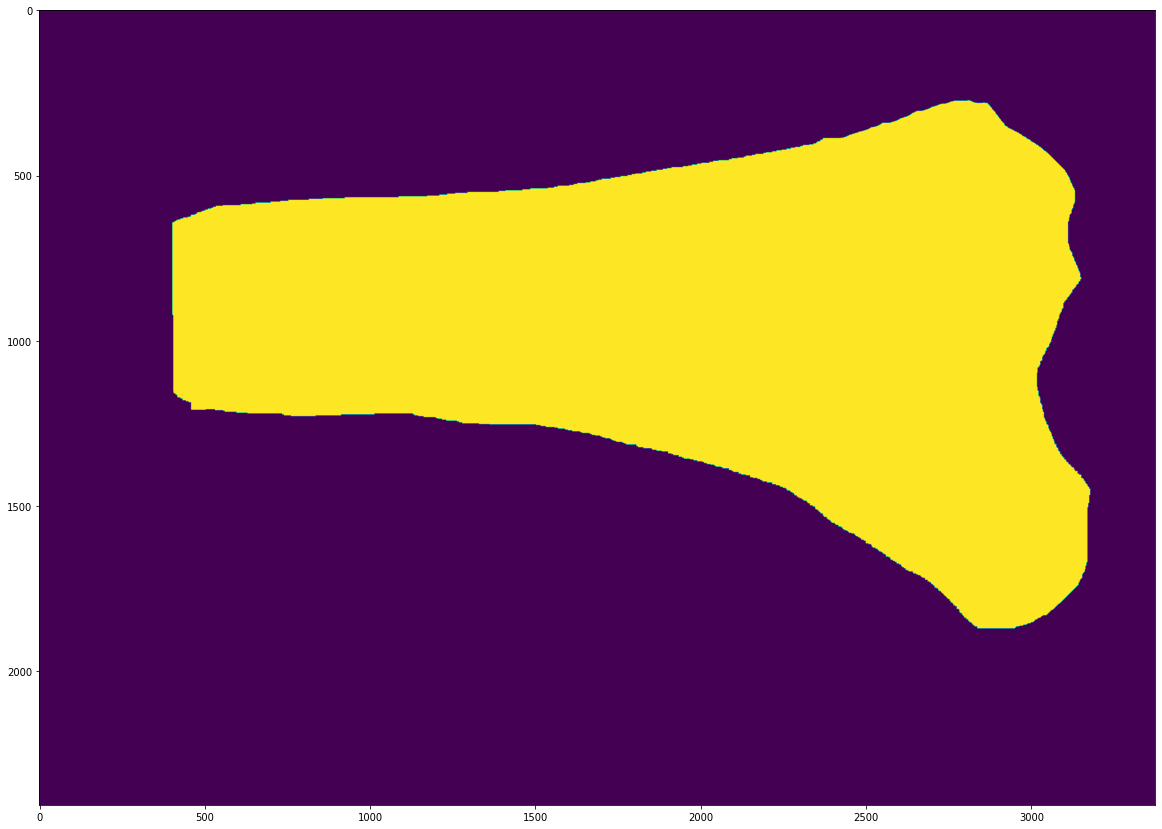

In [3]:
mask_path = "/home/dkermany/data/Bone_Project/masks/FV10__20190620_111343.seg.nrrd"

# Load mask from NRRD
mask, header = nrrd.read(mask_path)
mask = mask.T
mask = mask[:mask.shape[0]//3, :, :]

# Convert mask from uint8 to uint16
mask = mask.astype(np.uint16)
mask *= 2**16 - 1
print(mask.shape)
print(mask.dtype)

plt.figure(figsize=(20,20))
plt.imshow(mask[40])

In [4]:
tumor_csv_path = "/home/dkermany/data/Bone_Project/tumor_locations_09062022.csv"
# Load csv and drop rows with N/A's
tumor_csv = pd.read_csv(tumor_csv_path).dropna()
tumor_csv

,Filename,x (um),y (um),z (slice)
0,FV10__20190620_111343,2987,1760.0,76.0
1,FV10__20190620_111343,2975,1755.0,76.0
2,FV10__20190620_111343,2953,1715.0,76.0
3,FV10__20190620_111343,3079,1680.0,76.0
4,FV10__20190620_111343,2815,1342.0,76.0
5,FV10__20190620_111343,907,1229.0,76.0
6,FV10__20190620_111343,3015,875.0,76.0
7,FV10__20190620_111343,3021,861.0,76.0
8,FV10__20190620_111343,3055,910.0,76.0
9,FV10__20190620_111343,3271,1044.0,76.0



Tumor Location Marking
----------------------

In [5]:


# Filter tumors for the image in focus
tumor_csv = tumor_csv[tumor_csv.Filename == filename]
tumor_csv

,Filename,x (um),y (um),z (slice)
0,FV10__20190620_111343,2987,1760.0,76.0
1,FV10__20190620_111343,2975,1755.0,76.0
2,FV10__20190620_111343,2953,1715.0,76.0
3,FV10__20190620_111343,3079,1680.0,76.0
4,FV10__20190620_111343,2815,1342.0,76.0
5,FV10__20190620_111343,907,1229.0,76.0
6,FV10__20190620_111343,3015,875.0,76.0
7,FV10__20190620_111343,3021,861.0,76.0
8,FV10__20190620_111343,3055,910.0,76.0
9,FV10__20190620_111343,3271,1044.0,76.0


In [6]:
tumor_dict = tumor_csv.to_dict("index")
tumor_dict

{0: {'Filename': 'FV10__20190620_111343',
  'x (um)': '2987',
  'y (um)': 1760.0,
  'z (slice)': 76.0},
 1: {'Filename': 'FV10__20190620_111343',
  'x (um)': '2975',
  'y (um)': 1755.0,
  'z (slice)': 76.0},
 2: {'Filename': 'FV10__20190620_111343',
  'x (um)': '2953',
  'y (um)': 1715.0,
  'z (slice)': 76.0},
 3: {'Filename': 'FV10__20190620_111343',
  'x (um)': '3079',
  'y (um)': 1680.0,
  'z (slice)': 76.0},
 4: {'Filename': 'FV10__20190620_111343',
  'x (um)': '2815',
  'y (um)': 1342.0,
  'z (slice)': 76.0},
 5: {'Filename': 'FV10__20190620_111343',
  'x (um)': '907',
  'y (um)': 1229.0,
  'z (slice)': 76.0},
 6: {'Filename': 'FV10__20190620_111343',
  'x (um)': '3015',
  'y (um)': 875.0,
  'z (slice)': 76.0},
 7: {'Filename': 'FV10__20190620_111343',
  'x (um)': '3021',
  'y (um)': 861.0,
  'z (slice)': 76.0},
 8: {'Filename': 'FV10__20190620_111343',
  'x (um)': '3055',
  'y (um)': 910.0,
  'z (slice)': 76.0},
 9: {'Filename': 'FV10__20190620_111343',
  'x (um)': '3271',
  'y (

In [7]:
tumor_labels = np.zeros(viewer._arr.shape[1:], dtype=np.uint16)

In [8]:
def draw_sphere(x, y, z, r):
    """
    Coordinates and distances (x, y, z, r) given in pixels, NOT micrometers (um)
    """
    pass
    

In [9]:
for idx, tumor_info in tumor_dict.items():
    x_um, y_um, z_slice = map(int, (tumor_info["x (um)"], tumor_info["y (um)"], tumor_info["z (slice)"]))
    x, y, z = map(int, (x_um / x_step, y_um / y_step, z_slice-1))
    print(x, y, z)
    
    sphere_radius = 7 # micron
    sphere_z_slices = math.ceil(sphere_radius / z_step)
    
    min_z_step = max(0, z-sphere_z_slices)
    max_z_step = min(z+sphere_z_slices, viewer._arr.shape[1])

    # Label tumor
    for z_prime in range(min_z_step, max_z_step):
        cv2.circle(
            tumor_labels[z_prime],
            (x, y),
            radius=round((sphere_radius**2 - min((z_step*abs(z_prime-z))**2, sphere_radius**2))**0.5),
            color=(4096,4096,4096),
            thickness=-1,
        )
print(tumor_labels.shape)

2404 1417 75
2395 1413 75
2377 1380 75
2479 1352 75
2266 1080 75
730 989 75
2427 704 75
2432 693 75
2459 732 75
2633 840 75
2675 600 75
2771 595 75
2315 1432 66
2384 710 64
2351 721 62
2518 747 61
2344 1119 59
2301 1399 58
1892 647 53
1892 647 53
2336 1417 51
2351 1423 51
2799 592 48
2367 1393 43
1942 685 42
2411 1130 36
1928 668 35
2030 1294 26
1731 1243 26
823 752 13
1690 1226 4
2243 1351 0
2159 1356 0
2159 1338 0
2531 1475 0
(76, 2404, 3376)


In [10]:
total_image = np.concatenate((viewer._arr, np.expand_dims(tumor_labels, axis=0)), axis=0)
print(total_image.shape)
print("Total Image type:", total_image.dtype)

(4, 76, 2404, 3376)
Total Image type: uint16


In [11]:
# for i in range(tumor_labels.shape[0]):
#     plt.figure(figsize=(20,20))
#     plt.imshow(viewer.BGR2RGB(tumor_labels[i]))
#     plt.figure(figsize=(20,20))
#     plt.imshow(viewer.BGR2RGB(viewer._arr[0][i]))

NG2 Segmentation
---------------------------

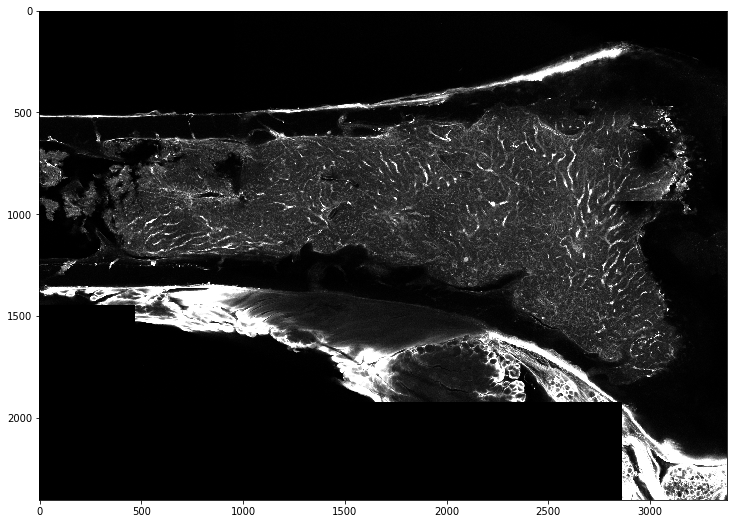

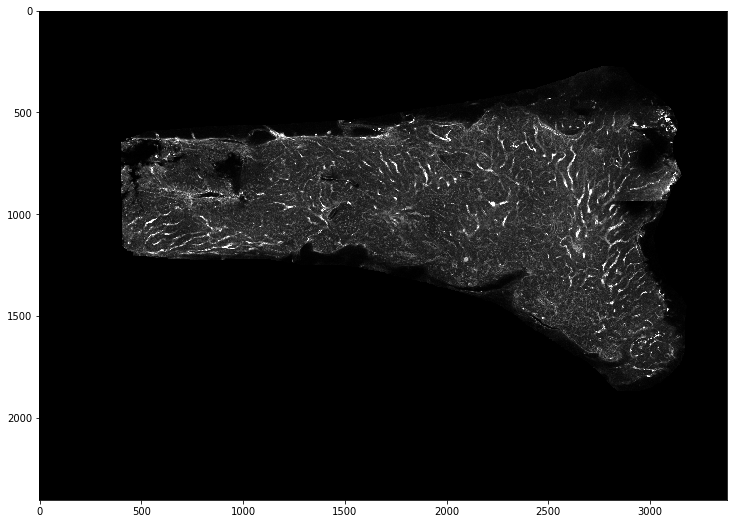

In [12]:
original_ng2 = cle.push(viewer.get_array()[1])
plt.figure(figsize=(16,9))
cle.imshow(original_ng2[40])

masked_ng2 = cle.mask(original_ng2, mask)
plt.figure(figsize=(16,9))
cle.imshow(masked_ng2[40])

del original_ng2

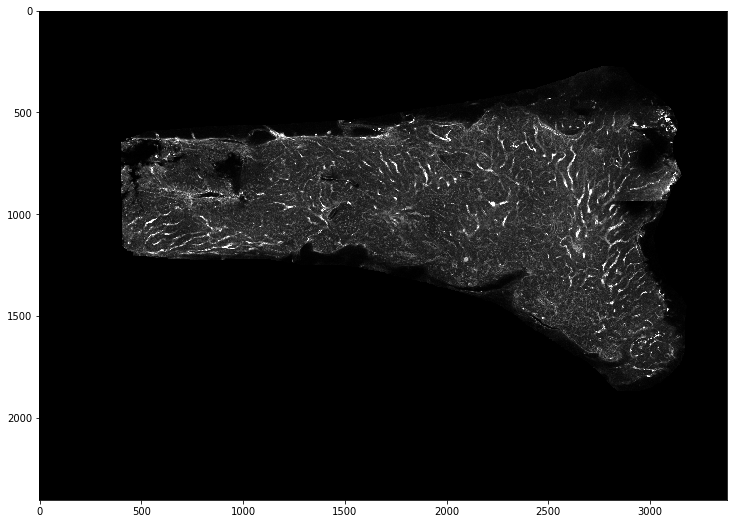

In [13]:


plt.figure(figsize=(16,9))
cle.imshow(masked_ng2[40])

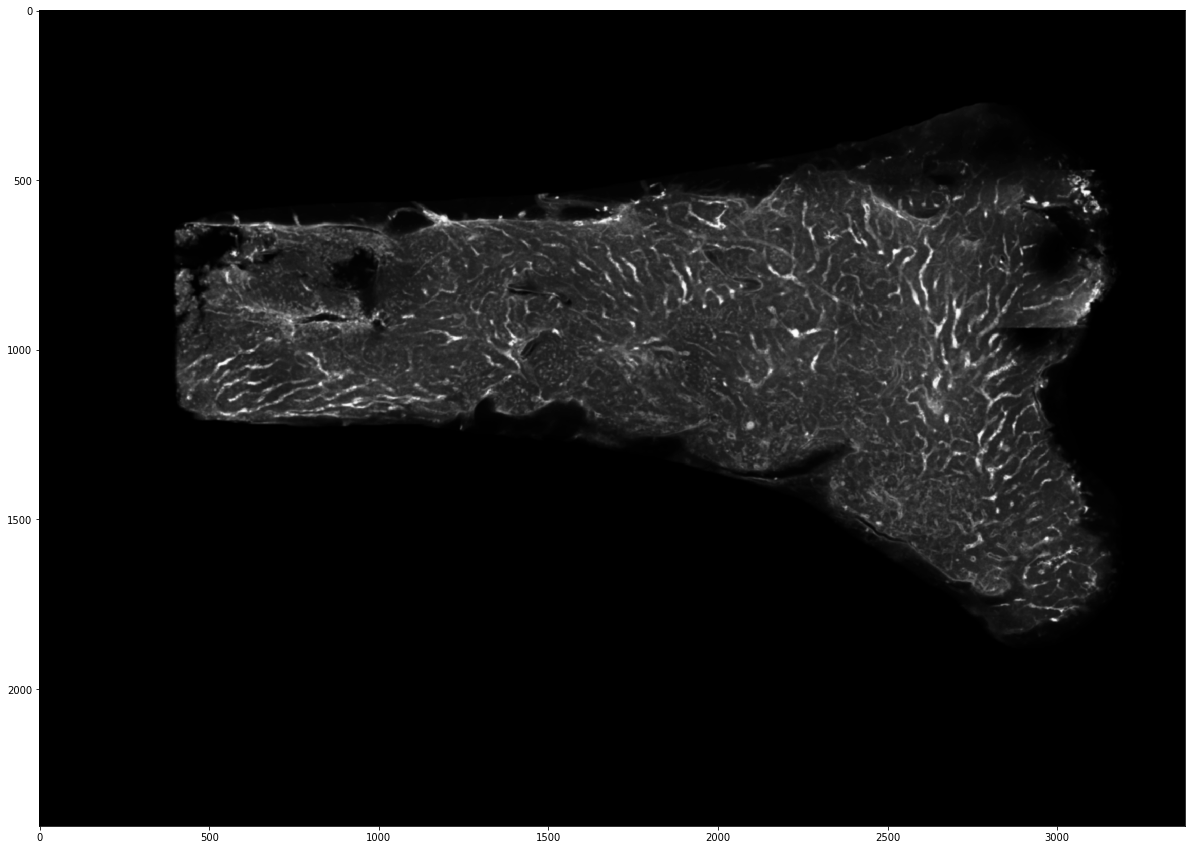

In [14]:
img_gaussian = cle.gaussian_blur(masked_ng2, sigma_x=2, sigma_y=2, sigma_z=2)
plt.figure(figsize=(30,15))
cle.imshow(img_gaussian[40])

del masked_ng2

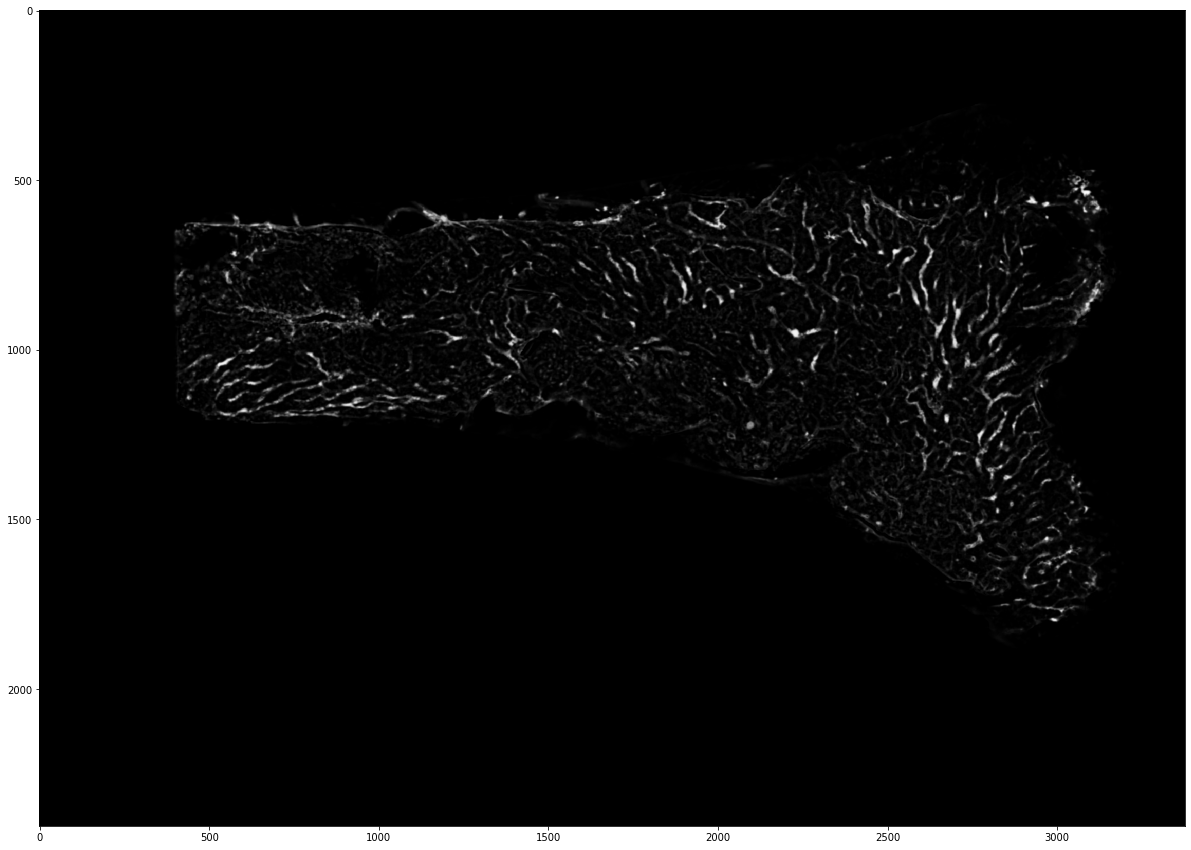

In [15]:
backgrund_subtracted = cle.top_hat_box(img_gaussian, radius_x=10, radius_y=10, radius_z=5)

plt.figure(figsize=(30,15))
cle.imshow(backgrund_subtracted[40])

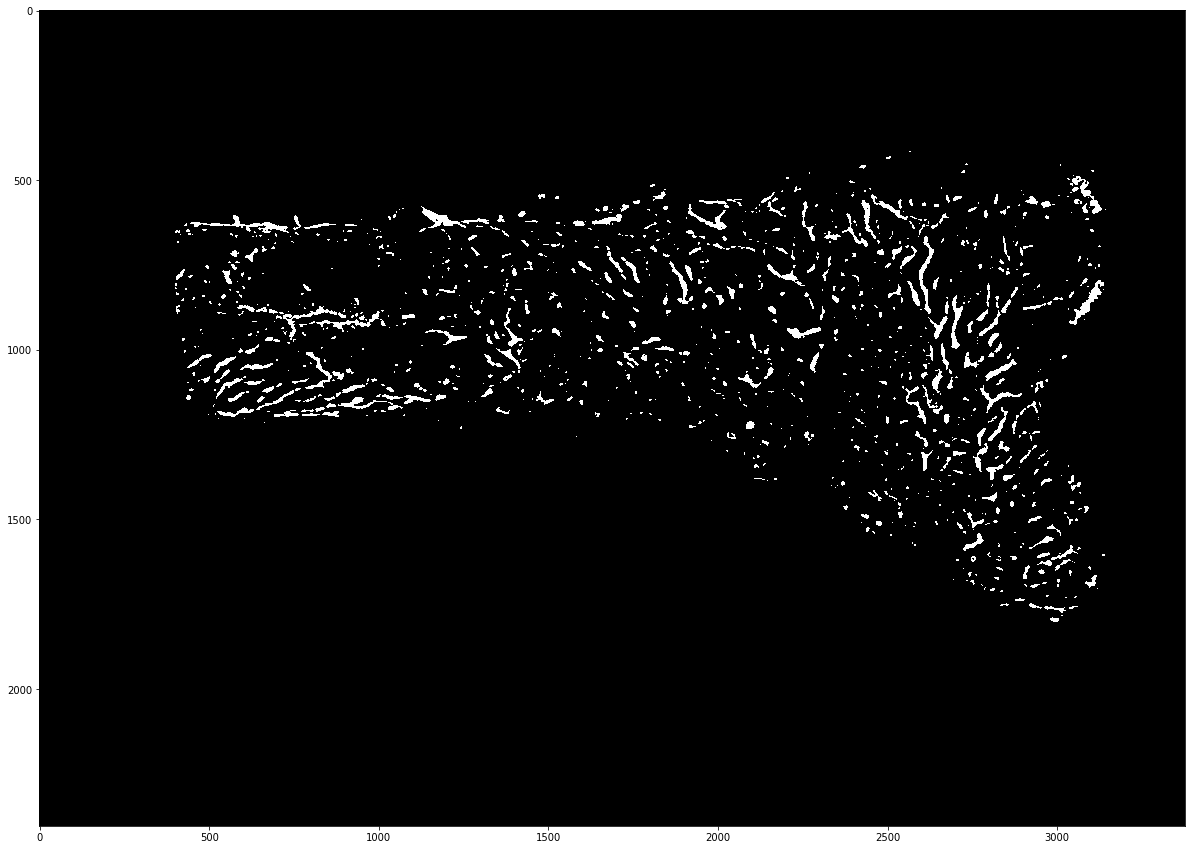

In [16]:
thresh2 = cle.threshold_otsu(backgrund_subtracted)

plt.figure(figsize=(30,15))
cle.imshow(thresh2[40])

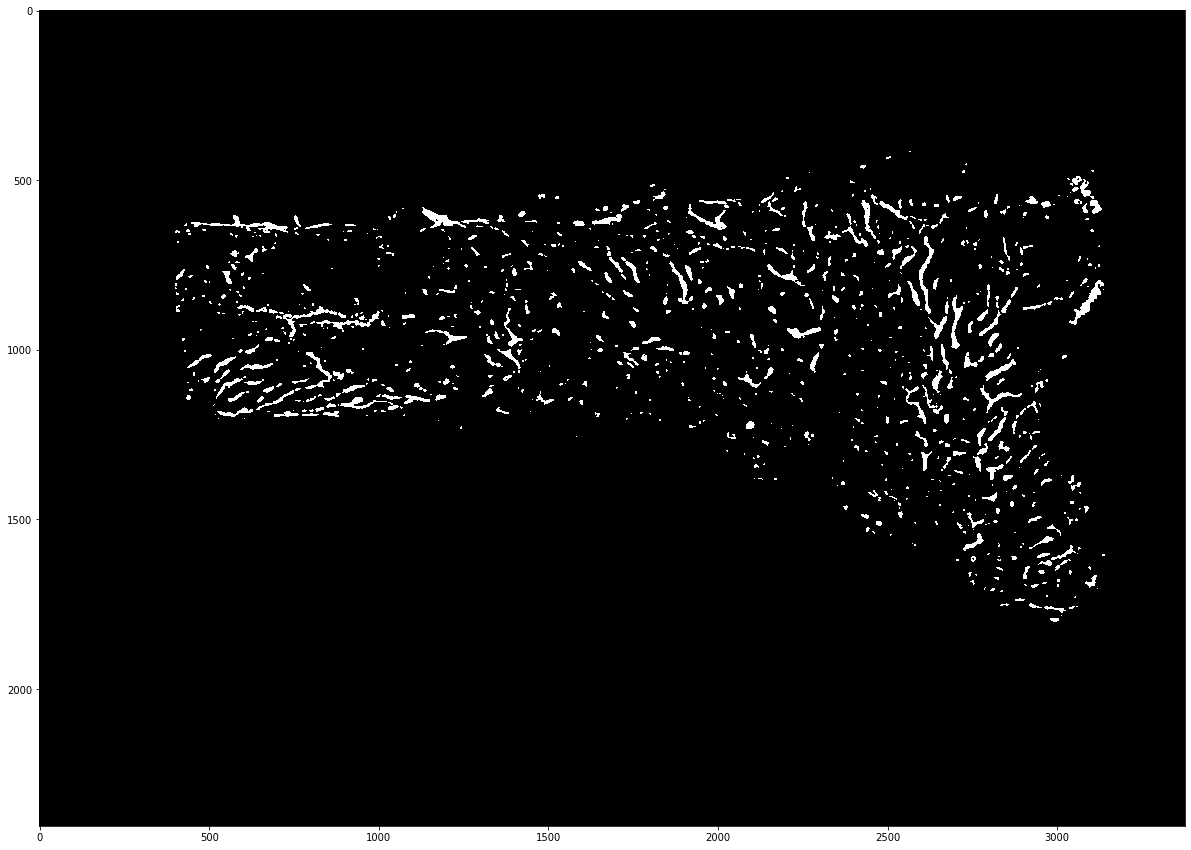

(76, 2404, 3376)


In [17]:
# Morphological opening
kernel = np.ones((5,5), np.uint8)
erosion = cle.erode_box(thresh2)
dilation = cle.dilate_box(erosion)

plt.figure(figsize=(30,15))
cle.imshow(dilation[40])
print(dilation.shape)

In [18]:
del erosion, thresh2, backgrund_subtracted, img_gaussian

(76, 2404, 3376)


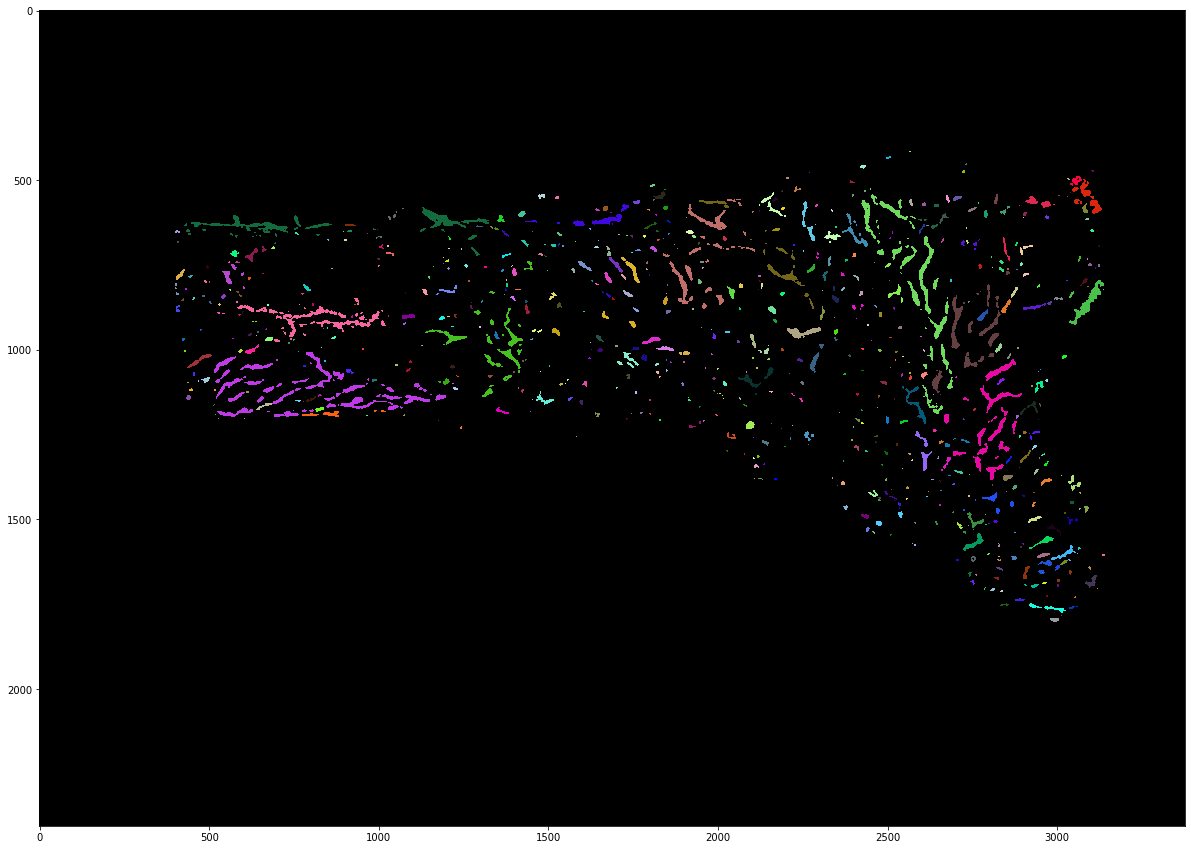

In [19]:
labels = cle.connected_components_labeling_box(dilation)
print(labels.shape)
plt.figure(figsize=(30,15))
cle.imshow(labels[40], labels=True)

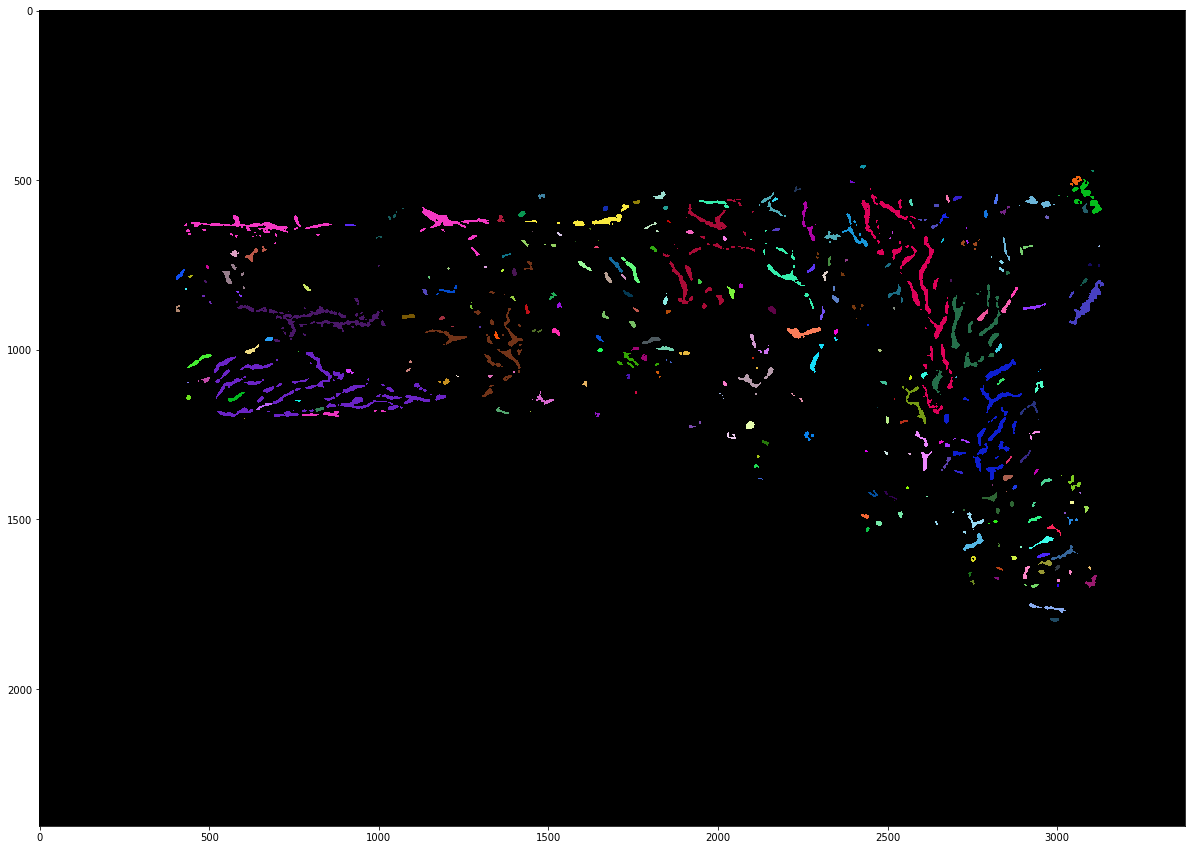

In [20]:
smalls_filtered_out = cle.exclude_labels_outside_size_range(labels, None, 2000, 1000000)
plt.figure(figsize=(30,15))
cle.imshow(smalls_filtered_out[40], labels=True)

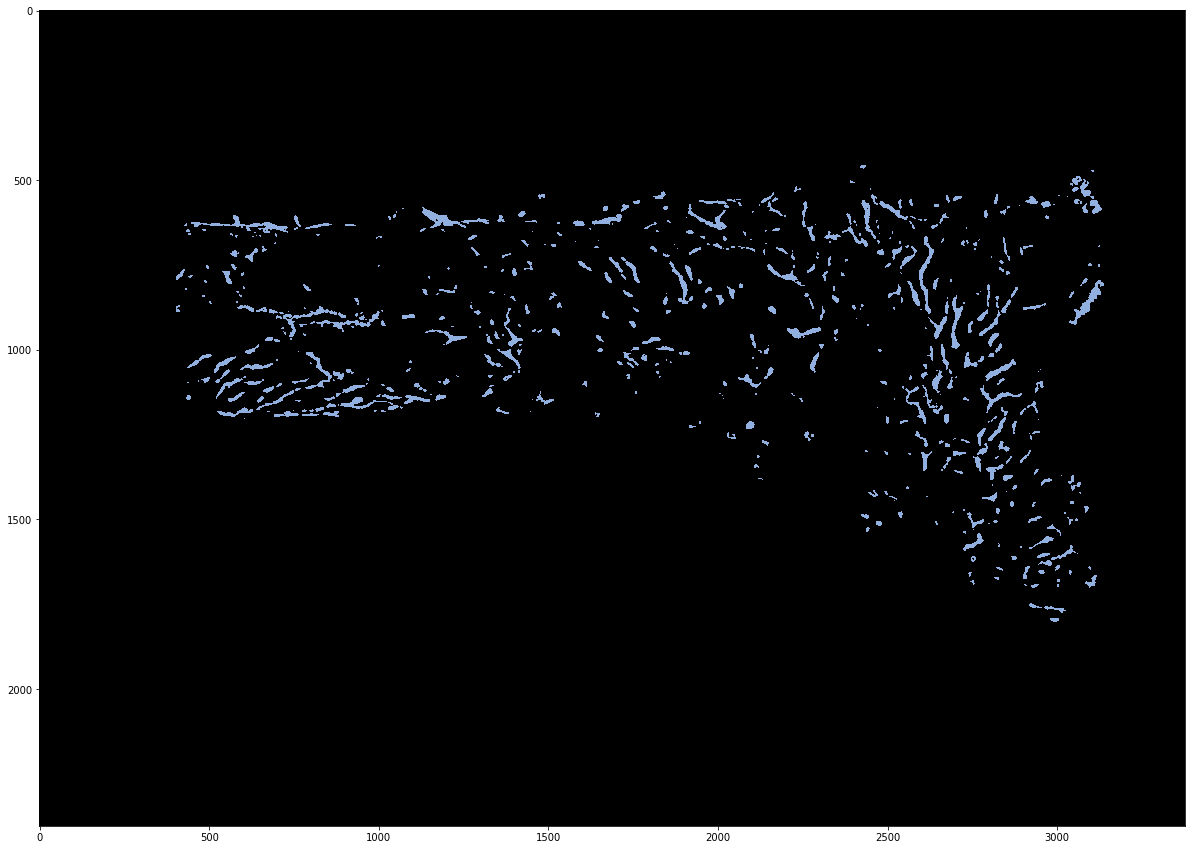

In [21]:
binarized = 2000 * (smalls_filtered_out > 0)
plt.figure(figsize=(30,15))
cle.imshow(binarized[40], labels=True)

In [22]:
total_image = np.concatenate((total_image, np.expand_dims(cle.pull(binarized), axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

del labels, smalls_filtered_out, binarized

(5, 76, 2404, 3376)
uint16


Vessel Segmentation
-----------------------------

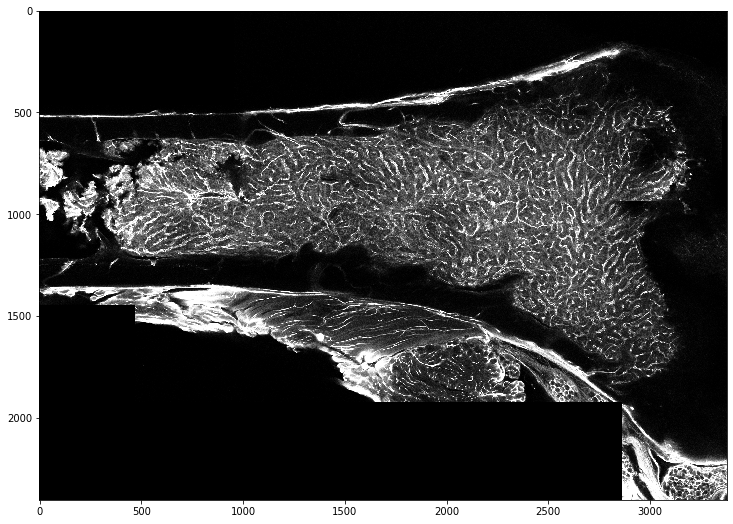

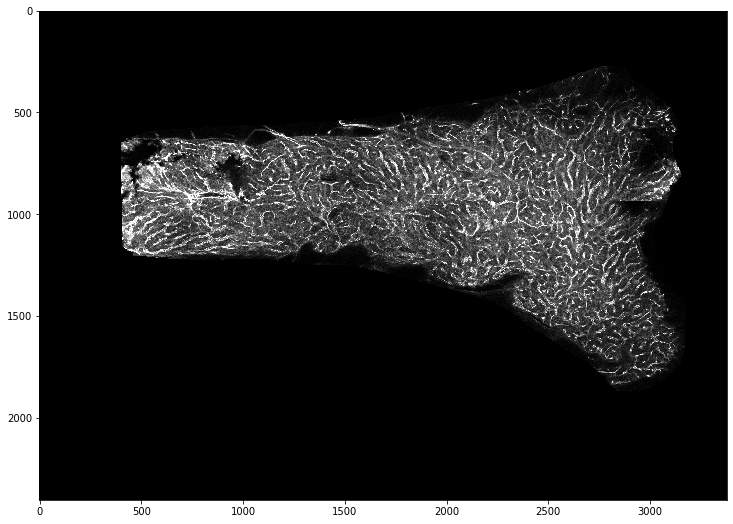

In [23]:
original_vessels = cle.push(viewer.get_array()[2])
plt.figure(figsize=(16,9))
cle.imshow(original_vessels[40])

masked_vessels = cle.mask(original_vessels, mask)
plt.figure(figsize=(16,9))
cle.imshow(masked_vessels[40])

del original_vessels

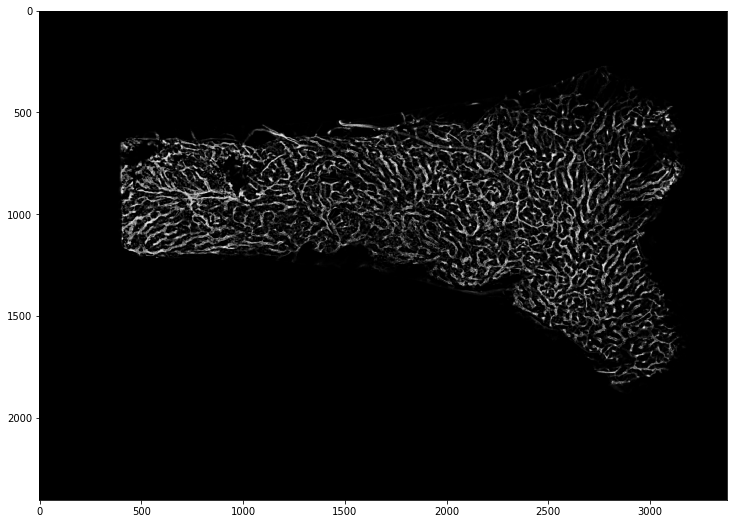

In [24]:
img_gaussian = cle.gaussian_blur(masked_vessels, sigma_x=2, sigma_y=2, sigma_z=2)
backgrund_subtracted = cle.top_hat_box(img_gaussian, radius_x=10, radius_y=10, radius_z=5)

plt.figure(figsize=(16,9))
cle.imshow(backgrund_subtracted[40])

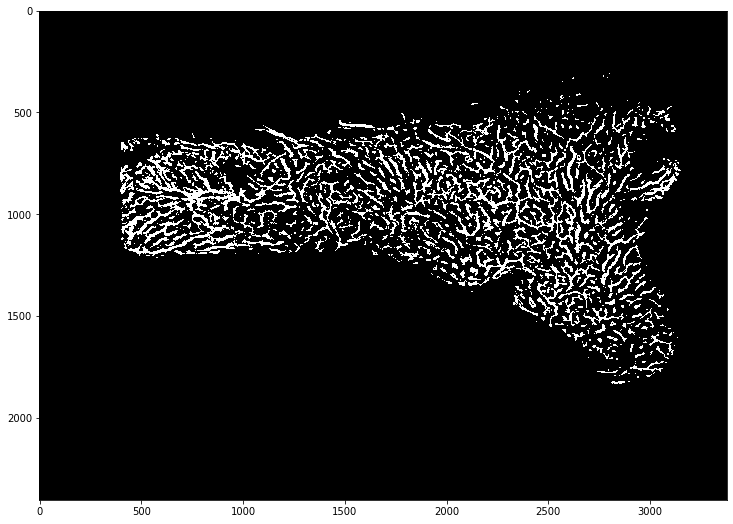

In [25]:
thresh2 = cle.threshold_otsu(backgrund_subtracted)

plt.figure(figsize=(16,9))
cle.imshow(thresh2[40])

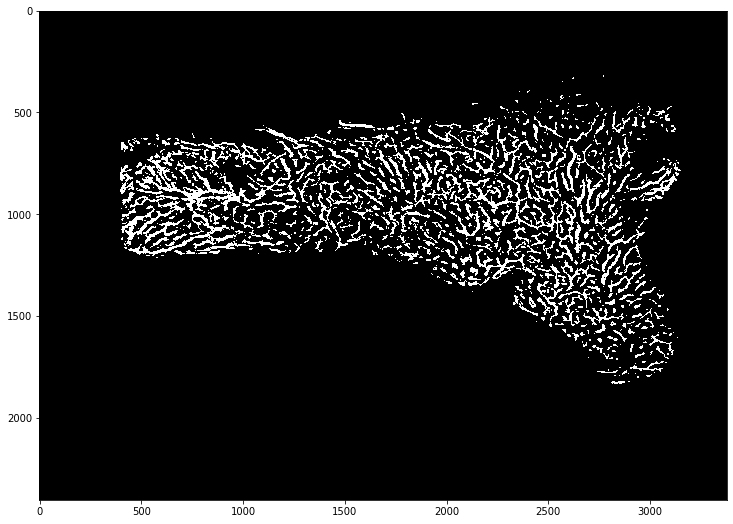

In [26]:
# Morphological openning
kernel = np.ones((7,7), np.uint8)
erosion = cle.erode_box(thresh2)
dilation = cle.dilate_box(erosion)

plt.figure(figsize=(16,9))
cle.imshow(dilation[40])

In [27]:
del erosion, backgrund_subtracted, img_gaussian

In [29]:
# Convert dilation from uint8 to uint16
dilation = dilation.astype(np.uint16)
dilation *= 2**10 - 1 #2**16 - 1

In [30]:
total_image = np.concatenate((total_image, np.expand_dims(cle.pull(dilation), axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

(6, 76, 2404, 3376)
uint16


In [31]:
total_image = np.concatenate((total_image, np.expand_dims(mask, axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

(7, 76, 2404, 3376)
uint16


In [32]:
viewer.save_as_tif_sequence(total_image, "/home/dkermany/data/Bone_Project/tif_sequences/FV10__20190620_111343/FV10__20190620_111343_7-channel")